In [1]:
import os


pos_train_data_path=r'data\aclImdb\train\pos'
neg_train_data_path=r'data\aclImdb\train\neg'
pos_test_data_path=r'data\aclImdb\test\pos'
neg_test_data_path=r'data\aclImdb\test\neg'


def read_texts(path):
    text_lst = []
    for filename in os.listdir(path):
        if filename[-4:] == '.txt':
            with open(os.path.join(path, filename), mode='tr', encoding="utf8") as file:
                text = file.read()
                text_lst.append(text)
    return text_lst


pos_train_data = read_texts(pos_train_data_path)
neg_train_data = read_texts(neg_train_data_path)
train_data = pos_train_data + neg_train_data
train_labels = [1] * len(pos_train_data) + [0] * len(neg_train_data)

In [2]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


N_tokens = 100
# N_training = 200
N_training = 15000
N_validation = 10000
N_words = 10000
N_embedding_dim = 8

tokenizer = Tokenizer(num_words=N_words)
tokenizer.fit_on_texts(train_data)
sequences = tokenizer.texts_to_sequences(train_data)
word_index_dct = tokenizer.word_index

X = pad_sequences(sequences, maxlen=N_tokens)
y = np.asarray(train_labels)

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]
X_train = X[:N_training]
y_train = y[:N_training]
X_val = X[N_training: N_training + N_validation]
y_val = y[N_training: N_training + N_validation]

In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(N_words, N_embedding_dim, input_length=N_tokens))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X, y,  epochs=10, batch_size=32, validation_split=0.2)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 8)            80000     
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 1)                 801       
                                                                 
Total params: 80801 (315.63 KB)
Trainable params: 80801 (315.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


625/625 [==============================] - 3s 5ms/step - loss: 0.6278 - acc: 0.6701 - val_loss: 0.4768 - val_acc: 0.8110
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3806 - acc: 0.8479 - val_loss: 0.3513 - val_acc: 0.8478
Epoch 3/10
625

In [4]:
glove_path = 'data\glove.6B'
filename = 'glove.6B.100d.txt'

glove_index_dct = {}
with open(os.path.join(glove_path, filename), mode='tr', encoding="utf8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        glove_index_dct[word] = coeffs

In [5]:
import numpy as np


N_words = 10000
N_tokens = 100
N_embedding_dim = 100

embedding_coeffs = np.zeros((N_words, N_embedding_dim))
for word, word_index in word_index_dct.items():
    if 1 < word_index <= N_words and word in glove_index_dct:
        embedding_coeffs[word_index-1] = glove_index_dct[word]

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense


model = Sequential()
model.add(Embedding(N_words, N_embedding_dim, input_length=N_tokens))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_coeffs])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                320032    
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1320065 (5.04 MB)
Trainable params: 1320065 (5.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
469/469 [==============================] - 4s 7ms/step - loss: 0.7057 - acc: 0.4973 - val_loss: 0.6933 - val_acc: 0.4931
Epoch 2/30
469/4

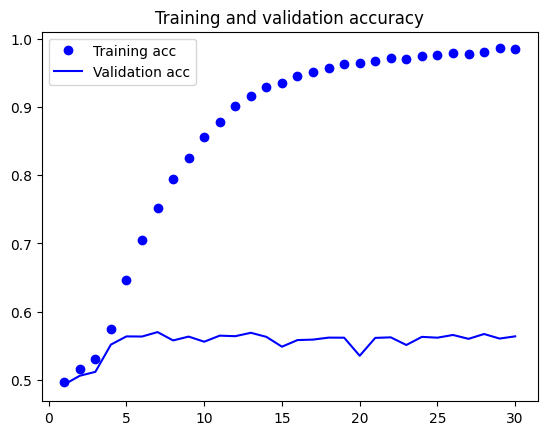

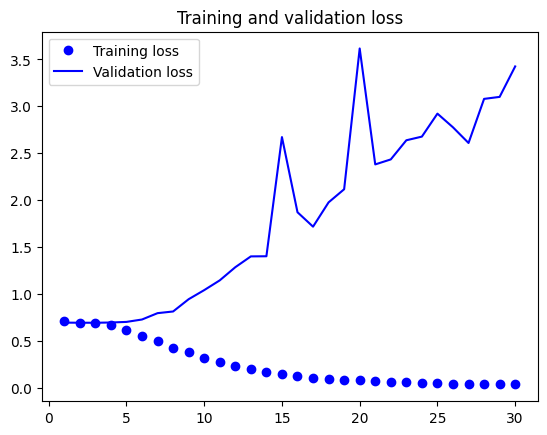

In [9]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()